In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import math
import keras
from random import shuffle
from keras.models import Sequential, Model
from keras.layers import Dense,Bidirectional
from keras.layers import LSTM, Flatten, Input
from keras.layers import BatchNormalization
from keras.layers import TimeDistributed, Conv1D, Conv2D, MaxPooling1D, GlobalMaxPooling1D,Dropout
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.optimizers import Adam

Using TensorFlow backend.
/Users/mariekorneliusson/anaconda3/envs/dml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [11]:
fold = 0
model = load_model('LSTM_1_2_3_New_Preprocessing_fold_0.h5')

In [3]:
path = os.path.normpath('/Users/mariekorneliusson/documents/AiSports/Strike_Data_As_Np')

In [4]:
X_First = np.load(path + '/' + 'X_First_Skier.npy')
Y_First = np.load(path + '/' + 'Y_First_Skier.npy')
feature_list_First = []
with open(path + "/keys_First_Skier.txt", "r") as f:
      for line in f:
        feature_list_First.append(line.strip('\n'))

In [5]:
X_Second = np.load(path + '/' + 'X_Second_Skier.npy')
Y_Second = np.load(path + '/' + 'Y_Second_Skier.npy')
feature_list_Second = []
with open(path + "/keys_Second_Skier.txt", "r") as f:
      for line in f:
        feature_list_Second.append(line.strip('\n'))

In [6]:
X_Third = np.load(path + '/' + 'X_Third_Skier.npy')
Y_Third = np.load(path + '/' + 'Y_Third_Skier.npy')
feature_list_Third = []
with open(path + "/keys_Third_Skier.txt", "r") as f:
      for line in f:
        feature_list_Third.append(line.strip('\n'))

In [8]:
feature_Dict = {i:feature_list_Second[i] for i in range(len(feature_list_Second)-1)}
print(len(feature_Dict))
time_step = 140
nbr_of_classes = 4

17


In [9]:
dim_X = len(feature_Dict)
X_List = [X_First,X_Second,X_Third]
Y_List = [Y_First,Y_Second,Y_Third]

folds = 5
X_fold_list = [[],[],[],[],[]]
Y_fold_list = [[],[],[],[],[]]

for i in range(len(X_List)):
    x_batch = X_List[i]
    y_batch = Y_List[i]
    for c in range(4):
        ind_c = np.where(y_batch[:,c] == 1)[0]
        if ind_c.shape[0] > 0:
            s = int(ind_c.shape[0]/folds)
            for i in range(folds-1):
                ind = ind_c[s*i:s*(i+1)]
                X_fold_list[i].append(x_batch[ind,:,:dim_X])
                Y_fold_list[i].append(y_batch[ind,:])
            ind = ind_c[s*(i+1):]
            X_fold_list[folds-1].append(x_batch[ind,:,:dim_X])
            Y_fold_list[folds-1].append(y_batch[ind,:])

In [10]:
X_fold_list_new = []
Y_fold_list_new = []
for i in range(folds):
    X_fold_list_new.append(np.concatenate(X_fold_list[i], axis=0))
    Y_fold_list_new.append(np.concatenate(Y_fold_list[i], axis=0))
    print(X_fold_list_new[i].shape)
    print(Y_fold_list_new[i].shape) 

(329, 140, 17)
(329, 4)
(329, 140, 17)
(329, 4)
(329, 140, 17)
(329, 4)
(329, 140, 17)
(329, 4)
(355, 140, 17)
(355, 4)


In [19]:
X_test = X_fold_list_new[0]
Y_test = Y_fold_list_new[0]

In [14]:
def change_time_axis_for_plot(X,delta_t):
    
    nbr_of_samples = X.shape[0]
    t = 0
    for i in range(nbr_of_samples):
        for j in range(140):
            X[i,j,0] = t*delta_t
            t = t + 1
    
    return X

In [15]:
def get_strike(strike,strike_l,pad):
    force_left = 1
    for j in range(strike_l-3):
        if strike[j,force_left] == strike[j+1,force_left] == strike[j+2,force_left] == pad:
        #if int(strike[j,1]) == int(strike[j+1,force_left]) == int(strike[j+2,force_left])  == pad :
            plot_strike = strike[0:j-1,force_left]
            time_strike = strike[0:j-1,0]
            print(j)
            break
        elif strike[strike_l-2,0] > 0.00000000:
            plot_strike = strike[:,force_left]
            time_strike = strike[:,0]
            break
    
    return plot_strike,time_strike

In [16]:
def plot_Results(X_Test,true_Y,pred_Y,figure,title):
    colorDict = {0:'navy',1:'r',2:'blue',3:'cyan'}
    nameDict = {0:'Gear 2',1:'Gear 3',2:'Gear 4',3:'Double','Gear 2':0,'Gear 3':1,'Gear 4':2,'Double':3}
    delta_t = 0.02
    X_Test = change_time_axis_for_plot(X_Test,delta_t)
    nbr_of_test = X_Test.shape[0]
    strike_l = X_Test.shape[1]
    pad = 0
    nbr_of_classes = 4
    font_s = 18
    
    for c in range(nbr_of_classes):
        true_c = np.where(true_Y == c)[0]
        pred_c = np.where(pred_Y == c)[0]
        strike_true = []
        strike_pred = []
        time_true = []
        time_pred = []
        for i in range(true_c.shape[0]):
            strike = X_Test[true_c[i],:,:]
            t_strike,t_time = get_strike(strike,strike_l,pad)
            strike_true.extend(t_strike)
            time_true.extend(t_time)
        for i in range(pred_c.shape[0]):
            strike = X_Test[pred_c[i],:,:]
            p_strike,p_time = get_strike(strike,strike_l,pad)
            strike_pred.extend(p_strike)
            time_pred.extend(p_time)

        plt.figure(figure,figsize=(15, 6))
        plt.title(title + ' Predicted gear',fontsize = font_s)
        plt.scatter(time_pred,strike_pred,label = 'Predicted gear: ' + nameDict[c],color =  colorDict[c], alpha = 1)
        plt.legend(fontsize = font_s)
        plt.xlabel('Time',fontsize = font_s)
        plt.ylabel('Force left',fontsize = font_s)
        plt.xticks(fontsize = font_s)
        plt.yticks(fontsize = font_s)


        plt.figure(figure+1,figsize=(15, 6))
        plt.title(title + ' True gear',fontsize = font_s)
        plt.scatter(time_true,strike_true,label = 'True gear: ' + nameDict[c],color =  colorDict[c], alpha = 1)
        plt.legend(fontsize = font_s)
        plt.xlabel('Time',fontsize = font_s)
        plt.ylabel('Force left',fontsize = font_s)
        plt.xticks(fontsize = font_s)
        plt.yticks(fontsize = font_s)
        
    figure = figure + 2
    return figure

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize = 14)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=14) 
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize = 14)
    plt.yticks(tick_marks, classes,fontsize = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True gear',fontsize = 14)
    plt.xlabel('Predicted gear',fontsize = 14)
    plt.tight_layout()

Normalized confusion matrix
[[0.94       0.02       0.04       0.        ]
 [0.07526882 0.90322581 0.01075269 0.01075269]
 [0.         0.01408451 0.98591549 0.        ]
 [0.         0.0173913  0.         0.9826087 ]]


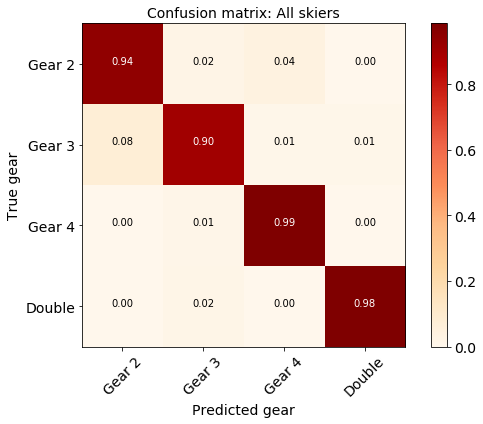

In [20]:
import itertools
from sklearn.metrics import confusion_matrix

class_names = ['Gear 2','Gear 3','Gear 4','Double']

predY = model.predict(X_test[:,:,1:])
pred_Y = np.argmax(predY,axis = 1)
true_Y = np.argmax(Y_test,axis = 1)

cnf_matrix = confusion_matrix(true_Y, pred_Y)
plt.figure(0,figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Confusion matrix: All skiers')


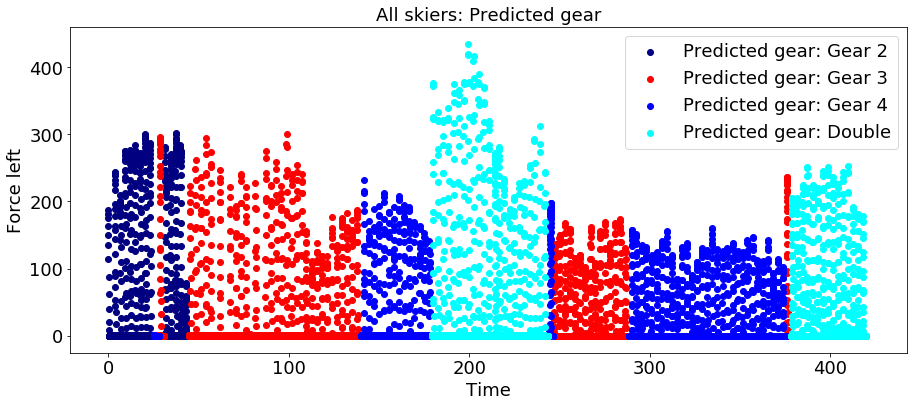

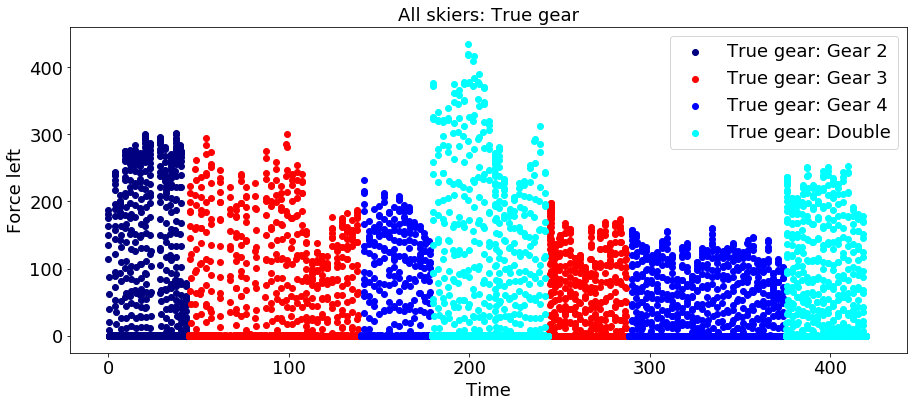

In [23]:
title = "All skiers:"
plot_points = 150
predY = model.predict(X_test[:plot_points,:,1:])
pred_Y = np.argmax(predY,axis = 1)
true_Y = np.argmax(Y_test[:plot_points,:],axis = 1)
figure = plot_Results(X_test,true_Y,pred_Y,0,title)